In [1]:
#Load all libraries
import pandas as pd
import numpy as np
import datetime as datetime
import datetime as timedelta
import pickle
import warnings
# These are the plotting modules and libraries we'll use:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# To make the plots appear in the iPython Notebook
%matplotlib inline
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

In [2]:
#Read all match results
results=pd.read_csv("D:\\Data Science\\World Cup\\results.csv")

results.head()

#Create Year column 
results['Year']=results.date.map(lambda x: x.split("-")[0])
results.Year = pd.to_numeric(results.Year)

results.Year.unique()

## Extract matches from 1900 only 
results = results[ results.Year<1872]

results.shape

#Create Year column 
results['Year']=results.date.map(lambda x: x.split("-")[2])
results.Year = pd.to_numeric(results.Year)

## Extract matches from 1925 only 
results = results[ results.Year>=1925]

results.shape

(38068, 9)

In [3]:
#results.to_csv("D:\\Data Science\\World Cup\\result_cleaned.csv")

In [4]:
# #Find list of countries played match from  1872-2018
# results_team_A=results.Team_A.unique()
# results_team_B = results.Team_B.unique()
# all_team_result = np.append(results_team_A,results_team_B)
# all_team_result=pd.Series(all_team_result)

# all_team_result=pd.Series(all_team_result.unique())

In [5]:
## Read all world cup matches starting from 1930 which is created by text extraction from each years data
world_cup_result=pd.read_excel("D:\\Data Science\\World Cup\\World-Cup-Master-Data.xlsx")

#Exclude 2018 world cup
historical_data=world_cup_result[(world_cup_result.Year < 2018) | ((world_cup_result.Year==2018) & (world_cup_result.Round=="Group")) ]
historical_data.Date = pd.to_datetime(historical_data.Date)
historical_data.head()

,Month,Place,Team_A,Team_B,Team_A_score,Team_B_score,Venue,City,Year,day,Date,Round,Winner_Team,Winner,rest
0,7,Uruguay,France,Mexico,4.0,1.0,Estadio Pocitos,Montevideo,1930,13,1930-07-13,Group,France,Team_A,(1) 13 July France 4-1 Mexico @ Estadio Pocito...
1,7,Uruguay,USA,Belgium,3.0,0.0,Estadio Parque Central,Montevideo,1930,13,1930-07-13,Group,USA,Team_A,(2) 13 July USA 3-0 Belgium @ Estadio Parque C...
2,7,Uruguay,Yugoslavia,Brazil,2.0,1.0,Estadio Parque Central,Montevideo,1930,14,1930-07-14,Group,Yugoslavia,Team_A,(3) 14 July Yugoslavia 2-1 Brazil @ Estadio Pa...
3,7,Uruguay,Romania,Peru,3.0,1.0,Estadio Pocitos,Montevideo,1930,14,1930-07-14,Group,Romania,Team_A,(4) 14 July Romania 3-1 Peru @ Estadio Pocitos...
4,7,Uruguay,Argentina,France,1.0,0.0,Estadio Parque Central,Montevideo,1930,15,1930-07-15,Group,Argentina,Team_A,(5) 15 July Argentina 1-0 France @ Estadio Par...


In [6]:
#Find list of countries played world cup from  1930
def filter_world_cup_playing_country(historical_data,results):
    all_team_A = historical_data.Team_A.unique()
    all_team_B = historical_data.Team_B.unique()
    all_team = np.append(all_team_A,all_team_B)
    all_team=pd.Series(all_team)

    #Conside matches played by all countries who have played worldcup
    results=results[ results.Team_A.isin(all_team) | results.Team_B.isin(all_team)]

    results.head()

    ##Convert date to datetime format
    results.date=pd.to_datetime(results.date)

    ##Select only relevent columns
    results=results[["date","Team_A","Team_B","Team_A_score","Team_B_score","tournament"]]

    #Rename date columns to Date
    results.rename(columns={'date': 'Date'},inplace=True)
    
    return (results)

In [7]:
results=filter_world_cup_playing_country(historical_data,results)

results.head()

,Date,Team_A,Team_B,Team_A_score,Team_B_score,tournament
834,1925-02-14,Scotland,Wales,3,1,British Championship
835,1925-02-28,Northern-Ireland,Scotland,0,3,British Championship
836,1925-02-28,Wales,England,1,2,British Championship
837,1925-03-15,Belgium,Netherlands,0,1,Friendly
838,1925-03-22,Austria,Switzerland,2,0,Friendly


In [8]:
##Function to create Winner attributes. 
def winner(x):
    if x.Team_A_score>x.Team_B_score:
        val = x.Team_A
    elif x.Team_A_score<x.Team_B_score:
        val = x.Team_B
    elif x.Team_A_score==x.Team_B_score:
        val = "Draw"
    return (val)        

In [9]:
##Apply winner function
results['Winner_Team']=results.apply(winner,axis=1)

results.head()

,Date,Team_A,Team_B,Team_A_score,Team_B_score,tournament,Winner_Team
834,1925-02-14,Scotland,Wales,3,1,British Championship,Scotland
835,1925-02-28,Northern-Ireland,Scotland,0,3,British Championship,Scotland
836,1925-02-28,Wales,England,1,2,British Championship,England
837,1925-03-15,Belgium,Netherlands,0,1,Friendly,Netherlands
838,1925-03-22,Austria,Switzerland,2,0,Friendly,Austria


In [10]:
### Include worldcup result from worldcup data 
results_wthout_worldcup = results[ ~(results.tournament=='FIFA World Cup')]

#Select relevent column to merge with all match result
world_cup_data=world_cup_result[["Date","Team_A","Team_B","Team_A_score","Team_B_score","Winner_Team"]]

results_wthout_worldcup.drop('tournament',axis=1,inplace=True)

#Merge both data
result_all_match=results_wthout_worldcup.append(world_cup_data)

result_all_match.Date=pd.to_datetime(result_all_match.Date)

result_all_match.head()

,Date,Team_A,Team_B,Team_A_score,Team_B_score,Winner_Team
834,1925-02-14,Scotland,Wales,3.0,1.0,Scotland
835,1925-02-28,Northern-Ireland,Scotland,0.0,3.0,Scotland
836,1925-02-28,Wales,England,1.0,2.0,England
837,1925-03-15,Belgium,Netherlands,0.0,1.0,Netherlands
838,1925-03-22,Austria,Switzerland,2.0,0.0,Austria


###########################################Feature Engineering Module starts here###############################################

In [11]:
### Calculate head to head performance for each country in world cup before each match
def wc_h2h_calculation(x):
    winner_count=[]

    for dt in x.Date.unique():
        prev_matches=historical_data[ historical_data.Date<dt]
        curr_matches=historical_data[ historical_data.Date==dt]
        
        for index in curr_matches.index:
            ht = curr_matches.Team_A[index]
            at = curr_matches.Team_B[index]
            win_ct=prev_matches[(prev_matches['Team_A'].isin([ht,at])) & (prev_matches['Team_B'].isin([ht,at]))].Winner_Team.value_counts()

            if (win_ct.shape[0]>1) & (win_ct.index.isin([ht,at]).sum()>1):

                ht_index=np.where(win_ct.index.isin([ht])==True)[0][0]

                at_index=np.where(win_ct.index.isin([at])==True)[0][0]

                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_head2head_win_wc':win_ct[ht_index],'Team_B_head2head_win_wc':win_ct[at_index],'No_of_match_head_2_head_wc':sum(win_ct)})

                #winner_count=winner_count.append(winner_temp)

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([ht,at]).sum()==1) & (win_ct.index.isin([ht]).sum()>0):

                #print ([ht,at])

                ht_index=np.where(win_ct.index.isin([ht])==True)[0][0]

                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_head2head_win_wc':win_ct[ht_index],'Team_B_head2head_win_wc':0,'No_of_match_head_2_head_wc':sum(win_ct)})

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([ht,at]).sum()==1) & (win_ct.index.isin([at]).sum()>0):

                #print ([ht,at])

                at_index=np.where(win_ct.index.isin([at])==True)[0][0]

                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_head2head_win_wc':0,'Team_B_head2head_win_wc':win_ct[at_index],'No_of_match_head_2_head_wc':sum(win_ct)})
            
            else:

                #print ([ht,at])

                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_head2head_win_wc':0,'Team_B_head2head_win_wc':0,'No_of_match_head_2_head_wc':0})

    winner_count_Worldcup=pd.DataFrame(winner_count)

    winner_count_Worldcup['Draw_wc']=winner_count_Worldcup.No_of_match_head_2_head_wc-(winner_count_Worldcup.Team_A_head2head_win_wc+winner_count_Worldcup.Team_B_head2head_win_wc)
    
    return (winner_count_Worldcup)

In [12]:
### Calculates head to head performance for each country before each match
def all_match_h2h_calculation(x):
    winner_count=[]

    for dt in x.Date.unique():
        prev_matches=result_all_match[ result_all_match.Date<dt]
        curr_matches=historical_data[ historical_data.Date==dt]
        
        for index in curr_matches.index:
            ht = curr_matches.Team_A[index]
            at = curr_matches.Team_B[index]        
            win_ct=prev_matches[(prev_matches['Team_A'].isin([ht,at])) & (prev_matches['Team_B'].isin([ht,at]))].Winner_Team.value_counts()

            if (win_ct.shape[0]>1) & (win_ct.index.isin([ht,at]).sum()>1):

                ht_index=np.where(win_ct.index.isin([ht])==True)[0][0]

                at_index=np.where(win_ct.index.isin([at])==True)[0][0]

                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_head2head_win_all_match':win_ct[ht_index],'Team_B_head2head_win_all_match':win_ct[at_index],'No_of_match_head_2_head_all':sum(win_ct)})

                #winner_count=winner_count.append(winner_temp)

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([ht,at]).sum()==1) & (win_ct.index.isin([ht]).sum()>0):

                #print ([ht,at])

                ht_index=np.where(win_ct.index.isin([ht])==True)[0][0]

                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_head2head_win_all_match':win_ct[ht_index],'Team_B_head2head_win_all_match':0,'No_of_match_head_2_head_all':sum(win_ct)})

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([ht,at]).sum()==1) & (win_ct.index.isin([at]).sum()>0):

                #print ([ht,at])

                at_index=np.where(win_ct.index.isin([at])==True)[0][0]

                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_head2head_win_all_match':0,'Team_B_head2head_win_all_match':win_ct[at_index],'No_of_match_head_2_head_all':sum(win_ct)})
            else:
                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_head2head_win_all_match':0,'Team_B_head2head_win_all_match':0,'No_of_match_head_2_head_all':0})
        
    winner_count_all_match=pd.DataFrame(winner_count)

    winner_count_all_match['Draw_all_match']=winner_count_all_match.No_of_match_head_2_head_all-(winner_count_all_match.Team_A_head2head_win_all_match+winner_count_all_match.Team_B_head2head_win_all_match)
    return (winner_count_all_match)

In [13]:
### Calculates head to head performance for each country before each match in last 10 years
def h2h_all_10yrs(x):
    
    #Function to calculate date before few years
    def subtract_years(dt, years):
        try:
            dt = dt.replace(year=dt.year-years)
        except ValueError:
            dt = dt.replace(year=dt.year-years, day=dt.day-1)
        return dt
    #historical_data.Date=pd.to_datetime(historical_data.Date)
    winner_count=[]
    x.Date=x.Date.astype('M8[ms]').astype('O')
    for dt in x.Date.unique():
        prev_matches=result_all_match[ (result_all_match.Date<dt) & (result_all_match.Date>subtract_years(dt,10))]
        curr_matches=historical_data[ historical_data.Date==dt]
        
        for index in curr_matches.index:
            ht = curr_matches.Team_A[index]
            at = curr_matches.Team_B[index]        
            win_ct=prev_matches[(prev_matches['Team_A'].isin([ht,at])) & (prev_matches['Team_B'].isin([ht,at]))].Winner_Team.value_counts()

            if (win_ct.shape[0]>1) & (win_ct.index.isin([ht,at]).sum()>1):

                ht_index=np.where(win_ct.index.isin([ht])==True)[0][0]

                at_index=np.where(win_ct.index.isin([at])==True)[0][0]

                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_win_all_match_10yr':win_ct[ht_index],'Team_B_win_all_match_10yr':win_ct[at_index],'No_of_match_head_2_head_all_10yr':sum(win_ct)})

                #winner_count=winner_count.append(winner_temp)

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([ht,at]).sum()==1) & (win_ct.index.isin([ht]).sum()>0):

                #print ([ht,at])

                ht_index=np.where(win_ct.index.isin([ht])==True)[0][0]

                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_win_all_match_10yr':win_ct[ht_index],'Team_B_win_all_match_10yr':0,'No_of_match_head_2_head_all_10yr':sum(win_ct)})

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([ht,at]).sum()==1) & (win_ct.index.isin([at]).sum()>0):

                #print ([ht,at])

                at_index=np.where(win_ct.index.isin([at])==True)[0][0]

                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_win_all_match_10yr':0,'Team_B_win_all_match_10yr':win_ct[at_index],'No_of_match_head_2_head_all_10yr':sum(win_ct)})
            else:
                winner_count.append({'Date': dt,'Team_A':ht,'Team_B':at,'Team_A_win_all_match_10yr':0,'Team_B_win_all_match_10yr':0,'No_of_match_head_2_head_all_10yr':0})
        
    winner_count_all_match_last_10_yr=pd.DataFrame(winner_count)

    winner_count_all_match_last_10_yr['Draw_all_match_10yr']=winner_count_all_match_last_10_yr.No_of_match_head_2_head_all_10yr-(winner_count_all_match_last_10_yr.Team_A_win_all_match_10yr+winner_count_all_match_last_10_yr.Team_B_win_all_match_10yr)
    
    return (winner_count_all_match_last_10_yr)

In [14]:
### Calculates each team performance in all matches
def team_performance_all_match(x):
    winner_count=[]

    for dt in x.Date.unique():
        prev_matches=result_all_match[ result_all_match.Date<dt]
        curr_matches=historical_data[ historical_data.Date==dt]
        
        for team_list in pd.Series(np.append(curr_matches.Team_A,curr_matches.Team_B)):
            
            no_of_matches = prev_matches[(prev_matches['Team_A'].isin([team_list])) | (prev_matches['Team_B'].isin([team_list]))]
            win_ct=no_of_matches.Winner_Team.value_counts()
            
            if (win_ct.shape[0]>1) & (win_ct.index.isin([team_list]).sum()==1):
                if win_ct.index.isin(["Draw"]).sum()==1:
                    draw=win_ct["Draw"]
                else:
                    draw=0
                ht_index=np.where(win_ct.index.isin([team_list])==True)[0][0]
                winner_count.append({'Date': dt,'Team':team_list,'all_match_win':win_ct[ht_index],'all_match_Draw':draw,'Total_match':no_of_matches.shape[0]})

                #winner_count=winner_count.append(winner_temp)

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([team_list]).sum()==1):

                winner_count.append({'Date': dt,'Team':team_list,'all_match_win':win_ct[0],'all_match_Draw':0,'Total_match':no_of_matches.shape[0]})

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([team_list]).sum()==0):
                if win_ct.index.isin(["Draw"]).sum()==1:
                    draw=win_ct["Draw"]
                else:
                    draw=0
                winner_count.append({'Date': dt,'Team':team_list,'all_match_win':0,'all_match_Draw':draw,'Total_match':no_of_matches.shape[0]})
        
    winner_count_team_performance_all_match=pd.DataFrame(winner_count)
    historical_data.Date = historical_data.Date.map(lambda x: np.datetime64(x))
    
    #Team_A
    winner_count_team_performance_all_match.rename(columns=({'all_match_win':'Team_A_all_match_win','all_match_Draw':'Team_A_all_match_Draw'}),inplace=True)
    right_df = winner_count_team_performance_all_match[['Date','Team','Team_A_all_match_win','Team_A_all_match_Draw']]
    World_cup_model_data = pd.merge(historical_data[['Date','Team_A','Team_B']],right_df,left_on=['Date','Team_A'],right_on=['Date','Team'],how='left')
    World_cup_model_data.drop(axis=1,labels='Team',inplace=True)
    #Team_B
    winner_count_team_performance_all_match.rename(columns=({'Team_A_all_match_win':'Team_B_all_match_win','Team_A_all_match_Draw':'Team_B_all_match_Draw'}),inplace=True)
    right_df = winner_count_team_performance_all_match[['Date','Team','Team_B_all_match_win','Team_B_all_match_Draw']]
    World_cup_model_data = pd.merge(World_cup_model_data,right_df,left_on=['Date','Team_B'],right_on=['Date','Team'],how='left')
    World_cup_model_data.drop(axis=1,labels='Team',inplace=True)
    return (World_cup_model_data)

In [15]:
### Calculates each team performance in world cup
def team_performance_wc_match(x):
    winner_count=[]

    for dt in x.Date.unique():
        prev_matches=historical_data[ historical_data.Date<dt]
        curr_matches=historical_data[ historical_data.Date==dt]
        
        for team_list in pd.Series(np.append(curr_matches.Team_A,curr_matches.Team_B)):
            
            no_of_matches = prev_matches[(prev_matches['Team_A'].isin([team_list])) | (prev_matches['Team_B'].isin([team_list]))]
            win_ct=no_of_matches.Winner_Team.value_counts()
            
            if (win_ct.shape[0]>1) & (win_ct.index.isin([team_list]).sum()==1):
                if win_ct.index.isin(["Draw"]).sum()==1:
                    draw=win_ct["Draw"]
                else:
                    draw=0
                ht_index=np.where(win_ct.index.isin([team_list])==True)[0][0]
                winner_count.append({'Date': dt,'Team':team_list,'wc_win':win_ct[ht_index],'wc_Draw':draw,'Total_match':no_of_matches.shape[0]})

                #winner_count=winner_count.append(winner_temp)

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([team_list]).sum()==1):

                winner_count.append({'Date': dt,'Team':team_list,'wc_win':win_ct[0],'wc_Draw':0,'Total_match':no_of_matches.shape[0]})

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([team_list]).sum()==0):
                if win_ct.index.isin(["Draw"]).sum()==1:
                    draw=win_ct["Draw"]
                else:
                    draw=0
                winner_count.append({'Date': dt,'Team':team_list,'wc_win':0,'wc_Draw':draw,'Total_match':no_of_matches.shape[0]})
        
    winner_count_team_performance_wc=pd.DataFrame(winner_count)
    historical_data.Date = historical_data.Date.map(lambda x: np.datetime64(x))
    #Team_A
    winner_count_team_performance_wc.rename(columns=({'wc_win':'Team_A_wc_win','wc_Draw':'Team_A_wc_Draw'}),inplace=True)
    right_df = winner_count_team_performance_wc[['Date','Team','Team_A_wc_win','Team_A_wc_Draw']]
    World_cup_model_data = pd.merge(historical_data[['Date','Team_A','Team_B']],right_df,left_on=['Date','Team_A'],right_on=['Date','Team'],how='left')
    World_cup_model_data.drop(axis=1,labels='Team',inplace=True)
    #Team_B
    winner_count_team_performance_wc.rename(columns=({'Team_A_wc_win':'Team_B_wc_win','Team_A_wc_Draw':'Team_B_wc_Draw'}),inplace=True)
    right_df = winner_count_team_performance_wc[['Date','Team','Team_B_wc_win','Team_B_wc_Draw']]
    World_cup_model_data = pd.merge(World_cup_model_data,right_df,left_on=['Date','Team_B'],right_on=['Date','Team'],how='left')
    World_cup_model_data.drop(axis=1,labels='Team',inplace=True)
    
    return (World_cup_model_data)

In [16]:
### Calculates each team performance in last 10 match
def team_performance_all_match_10yr(x):
    winner_count=[]

    for dt in x.Date.unique():
        prev_matches=result_all_match[ result_all_match.Date<dt]
        curr_matches=historical_data[ historical_data.Date==dt]
        for team_list in pd.Series(np.append(curr_matches.Team_A,curr_matches.Team_B)):
            
            no_of_matches = prev_matches[(prev_matches['Team_A'].isin([team_list])) | (prev_matches['Team_B'].isin([team_list]))]
            no_of_matches = no_of_matches.sort_values(by='Date',ascending=False).head(10)
            win_ct=no_of_matches.Winner_Team.value_counts()
            
            if (win_ct.shape[0]>1) & (win_ct.index.isin([team_list]).sum()==1):
                if win_ct.index.isin(["Draw"]).sum()==1:
                    draw=win_ct["Draw"]
                else:
                    draw=0
                ht_index=np.where(win_ct.index.isin([team_list])==True)[0][0]
                winner_count.append({'Date': dt,'Team':team_list,'last_10_match_win':win_ct[ht_index],'last_10_match_Draw':draw,'Total_match':no_of_matches.shape[0]})

                #winner_count=winner_count.append(winner_temp)

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([team_list]).sum()==1):

                winner_count.append({'Date': dt,'Team':team_list,'last_10_match_win':win_ct[0],'last_10_match_Draw':0,'Total_match':no_of_matches.shape[0]})

            elif (win_ct.shape[0]==1) & (win_ct.index.isin([team_list]).sum()==0):
                if win_ct.index.isin(["Draw"]).sum()==1:
                    draw=win_ct["Draw"]
                else:
                    draw=0
                winner_count.append({'Date': dt,'Team':team_list,'last_10_match_win':0,'last_10_match_Draw':draw,'Total_match':no_of_matches.shape[0]})
        
    winner_count_team_performance_last_10_match=pd.DataFrame(winner_count)
    historical_data.Date = historical_data.Date.map(lambda x: np.datetime64(x))
    #Team_A
    winner_count_team_performance_last_10_match.rename(columns=({'last_10_match_win':'Team_A_last_10_match_win','last_10_match_Draw':'Team_A_last_10_match_Draw'}),inplace=True)
    right_df = winner_count_team_performance_last_10_match[['Date','Team','Team_A_last_10_match_win','Team_A_last_10_match_Draw']]
    World_cup_model_data = pd.merge(historical_data[['Date','Team_A','Team_B']],right_df,left_on=['Date','Team_A'],right_on=['Date','Team'],how='left')
    World_cup_model_data.drop(axis=1,labels='Team',inplace=True)
    #Team_B
    winner_count_team_performance_last_10_match.rename(columns=({'Team_A_last_10_match_win':'Team_B_last_10_match_win','Team_A_last_10_match_Draw':'Team_B_last_10_match_Draw'}),inplace=True)
    right_df = winner_count_team_performance_last_10_match[['Date','Team','Team_B_last_10_match_win','Team_B_last_10_match_Draw']]
    World_cup_model_data = pd.merge(World_cup_model_data,right_df,left_on=['Date','Team_B'],right_on=['Date','Team'],how='left')
    World_cup_model_data.drop(axis=1,labels='Team',inplace=True)
    
    return (World_cup_model_data)

In [17]:
#Extract Rank information
def rank_calculation(x):
    
    #Extract rank information from 1993-09 - present
    Rank=pd.read_excel("D:\\Data Science\\World Cup\\Rank File.xlsx")

    # unpivot the data
    Rank=pd.melt(Rank, id_vars=['Date'], var_name='Team', value_name='Rank')

    #Create Year and Month column
    Rank['Year'] = pd.to_numeric(Rank.Date.map(lambda x: x.year))
    Rank['Month']=pd.to_numeric(Rank.Date.map(lambda x: x.month))
    
    if min(x.Date)<datetime.datetime(1993,7,1):
        result_all_match_rank = results.copy()

        result_all_match_rank['Month']=result_all_match_rank.Date.map(lambda x: x.month)
        result_all_match_rank['Year']=result_all_match_rank.Date.map(lambda x: x.year)

        result_all_match_rank['Year']=result_all_match_rank['Year']+result_all_match_rank['Month']/12

        #Calculate Rank for teams before ranking system starts on 1993-08
        winner_count=[]
        for year in np.arange(1930,1993.6,1/12):
            sel_df = result_all_match_rank[ result_all_match_rank.Year<year]
    
            for team_list in pd.Series(np.append(sel_df.Team_A.unique(),sel_df.Team_B.unique())).unique():
                no_of_matches = sel_df[(sel_df['Team_A'].isin([team_list])) | (sel_df['Team_B'].isin([team_list]))]
                win_ct=no_of_matches.Winner_Team.value_counts()
                if sum(win_ct.index.isin([team_list]))==1 :
                    win_pt = win_ct[np.where(win_ct.index.isin([team_list])==True)[0][0]]
                else:
                    win_pt = 0
                if sum(win_ct.index.isin(["Draw"]))==1:
                    Draw_pt = win_ct[np.where(win_ct.index.isin(["Draw"])==True)[0][0]]
                else:
                    Draw_pt = 0
        
                point = win_pt*3+Draw_pt*1
                winner_count.append({'Year': year,'Team':team_list,'Point':point})
                
        Team_Rank_before_1993_7=pd.DataFrame(winner_count)
        #if else need to use

        Team_Rank_before_1993_7=Team_Rank_before_1993_7.sort_values(by=['Year','Point'],ascending=[1,0])

        Team_Rank_before_1993_7['Rank']=Team_Rank_before_1993_7.groupby(['Year'])['Point'].rank(ascending=False,method='dense')

        def month_conversion(x):
            month=(x%int(x))*12
            Year = int(x)
            if month==0:
                month = 12
                Year = Year-1
            return (month,Year)

        nec = Team_Rank_before_1993_7['Year'].apply(month_conversion)

        Team_Rank_before_1993_7['Month']=nec.map(lambda x: x[0])
        Team_Rank_before_1993_7['Year']=nec.map(lambda x: x[1])

        Team_Rank_before_1993_7.to_csv("D:\\Data Science\\World Cup\\Team_Rank_before_1993_7.csv")

    Team_Rank_before_1993_7=pd.read_csv("D:\\Data Science\\World Cup\\Team_Rank_before_1993_7.csv")
    Rank=pd.concat([Team_Rank_before_1993_7[['Year','Month','Team','Rank']],Rank[['Year','Month','Team','Rank']]],ignore_index=True)
     

    Rank.Year = np.int64(Rank.Year)
    Rank.Month = np.int64(Rank.Month)
    Rank.Rank = np.int64(Rank.Rank)

    def add_one_month(x):
        if x.Month < 12:
            month1=x.Month+1
            year1=x.Year
        elif x.Month==12:
            month1=1
            year1=(x.Year+1)
        return [month1,year1]

    next_value=Rank[['Month','Year']].apply(add_one_month,axis=1)

    Rank['Next_Month']=next_value.map(lambda x: x[0])
    Rank['Next_Year']=next_value.map(lambda x: x[1])

    def month_processing(x):
        if (x.Month > 6) & (x.Year==2018):
            month1=6
        else :
            month1=x.Month
        return (month1)

    temp_rank_df=historical_data.copy()

    temp_rank_df['Changed_Month']=temp_rank_df[['Month','Year']].apply(month_processing,axis=1)
    
    #merge with world cup result data 
    #Includes Team_A rank
    rank_df=pd.merge(temp_rank_df[['Month','Changed_Month','Year','Team_A','Team_B']],Rank[['Next_Month','Next_Year','Team','Rank']],left_on=['Changed_Month','Year','Team_A'],right_on=['Next_Month','Next_Year','Team'],how='left')
    rank_df.drop(axis=1,labels=['Next_Month','Next_Year','Team'],inplace=True)
    rank_df.rename(columns={'Rank':'Rank_Team_A'},inplace=True)

    #merge with world cup result data 
    #Includes Team_B rank
    rank_df=pd.merge(rank_df,Rank[['Next_Month','Next_Year','Team','Rank']],left_on=['Changed_Month','Year','Team_B'],right_on=['Next_Month','Next_Year','Team'],how='left')
    rank_df.drop(axis=1,labels=['Next_Month','Next_Year','Team'],inplace=True)
    rank_df.rename(columns={'Rank':'Rank_Team_B'},inplace=True)
    
    return (rank_df)
    


In [18]:
#Calculate each team's participation
def appearance_calculation(x):
    Appearance_df=[]
    for year in x.Year.unique():
        filtered_df=historical_data[(historical_data.Year<year)]
        curr_filter_df = historical_data[(historical_data.Year==year)]
        for team in pd.Series(np.append(curr_filter_df.Team_A,curr_filter_df.Team_B)).unique():
            filtered_df_team=filtered_df[(filtered_df.Team_A==team) | (filtered_df.Team_B==team)]
            Appearance_df.append({'Year':year,'Team':team,'Appearance':filtered_df_team.shape[0]})
    Appearance_df=pd.DataFrame(Appearance_df)

    #merge with world cup result data 
    #Includes Team_A Appearance
    World_cup_Appearance_df=pd.merge(historical_data[['Year','Team_A','Team_B']],Appearance_df,left_on=['Team_A','Year'],right_on=['Team','Year'],how='left')
    World_cup_Appearance_df.drop(axis=1,labels=['Team'],inplace=True)
    World_cup_Appearance_df.rename(columns={'Appearance':'Appearance_Team_A'},inplace=True)

    #merge with world cup result data 
    #Includes Team_B Appearance
    World_cup_Appearance_df=pd.merge(World_cup_Appearance_df,Appearance_df,left_on=['Team_B','Year'],right_on=['Team','Year'],how='left')
    World_cup_Appearance_df.drop(axis=1,labels=['Team'],inplace=True)
    World_cup_Appearance_df.rename(columns={'Appearance':'Appearance_Team_B'},inplace=True)
    
    return (World_cup_Appearance_df)

In [19]:
def missing_value_imputation():
    #Missing imputation using 0 for attributes which is NA as they have not played before

    World_cup_final_data.No_of_match_head_2_head_wc.fillna(0,inplace=True)
    World_cup_final_data.Team_A_head2head_win_wc.fillna(0,inplace=True)
    World_cup_final_data.Team_B_head2head_win_wc.fillna(0,inplace=True)
    World_cup_final_data.Draw_wc.fillna(0,inplace=True)

    World_cup_final_data.No_of_match_head_2_head_all.fillna(0,inplace=True)
    World_cup_final_data.Team_A_head2head_win_all_match.fillna(0,inplace=True)
    World_cup_final_data.Team_B_head2head_win_all_match.fillna(0,inplace=True)
    World_cup_final_data.Draw_all_match.fillna(0,inplace=True)

    World_cup_final_data.No_of_match_head_2_head_all_10yr.fillna(0,inplace=True)
    World_cup_final_data.Team_A_win_all_match_10yr.fillna(0,inplace=True)
    World_cup_final_data.Team_B_win_all_match_10yr.fillna(0,inplace=True)
    World_cup_final_data.Draw_all_match_10yr.fillna(0,inplace=True)

    World_cup_final_data.Team_A_all_match_win.fillna(0,inplace=True)
    World_cup_final_data.Team_A_all_match_Draw.fillna(0,inplace=True)
    World_cup_final_data.Team_B_all_match_win.fillna(0,inplace=True)
    World_cup_final_data.Team_B_all_match_Draw.fillna(0,inplace=True)

    World_cup_final_data.Team_A_wc_win.fillna(0,inplace=True)
    World_cup_final_data.Team_A_wc_Draw.fillna(0,inplace=True)
    World_cup_final_data.Team_B_wc_win.fillna(0,inplace=True)
    World_cup_final_data.Team_B_wc_Draw.fillna(0,inplace=True)

    World_cup_final_data.Team_A_last_10_match_win.fillna(0,inplace=True)
    World_cup_final_data.Team_A_last_10_match_Draw.fillna(0,inplace=True)
    World_cup_final_data.Team_B_last_10_match_win.fillna(0,inplace=True)
    World_cup_final_data.Team_B_last_10_match_Draw.fillna(0,inplace=True)

    World_cup_final_data['Rank_Team_A']=World_cup_final_data.groupby(["Year","Team_A"]).transform(lambda x: x.fillna(x.mean()))['Rank_Team_A']
    World_cup_final_data['Rank_Team_B']=World_cup_final_data.groupby(["Year","Team_B"]).transform(lambda x: x.fillna(x.mean()))['Rank_Team_B']
    return (World_cup_final_data)

In [20]:
###Create comparative features
def comparative_feature_engineering(World_cup_final_data):
    World_cup_final_data['win_diff_h2h_wc_match'] = World_cup_final_data.Team_A_head2head_win_wc - World_cup_final_data.Team_A_head2head_win_wc
    World_cup_final_data['draw_h2h_wc_per_match'] = World_cup_final_data.Draw_wc/World_cup_final_data.No_of_match_head_2_head_wc

    World_cup_final_data['win_diff_h2h_all_match'] = World_cup_final_data.Team_A_head2head_win_all_match - World_cup_final_data.Team_B_head2head_win_all_match
    World_cup_final_data['draw_h2h_all_per_match'] = World_cup_final_data.Draw_all_match/World_cup_final_data.No_of_match_head_2_head_all
    World_cup_final_data['win_diff_h2h_all_match_percent'] = World_cup_final_data.win_diff_h2h_all_match /World_cup_final_data.No_of_match_head_2_head_all

    World_cup_final_data['win_diff_h2h_all_match_10yr'] = World_cup_final_data.Team_A_win_all_match_10yr - World_cup_final_data.Team_B_win_all_match_10yr
    World_cup_final_data['draw_h2h_all_per_match_10yr'] = World_cup_final_data.Draw_all_match_10yr/World_cup_final_data.No_of_match_head_2_head_all_10yr

    World_cup_final_data['win_percent_diff_wc'] = (World_cup_final_data.Team_A_wc_win/World_cup_final_data.Appearance_Team_A)-(World_cup_final_data.Team_B_wc_win/World_cup_final_data.Appearance_Team_B)
    World_cup_final_data['Draw_percent_diff_wc'] = (World_cup_final_data.Team_A_wc_Draw/World_cup_final_data.Appearance_Team_A)-(World_cup_final_data.Team_B_wc_Draw/World_cup_final_data.Appearance_Team_B)

    World_cup_final_data['win_diff_last_10_match'] = World_cup_final_data.Team_A_last_10_match_win-World_cup_final_data.Team_B_last_10_match_win

    World_cup_final_data['Rank_diff'] = World_cup_final_data.Rank_Team_A - World_cup_final_data.Rank_Team_B

    World_cup_final_data['Appearance_diff'] = World_cup_final_data.Appearance_Team_A - World_cup_final_data.Appearance_Team_B
    return (World_cup_final_data)

In [21]:
##Function which call all feature engineering function and missing value imputation and returns required features. This function takes some time to run.
def feature_engineering_module(x):
    x.Date=x.Date.map(lambda x: np.datetime64(x))
    winner_count_Worldcup=wc_h2h_calculation(x)
    print("World cup head to head statistics complete...")
    winner_count_all_match=all_match_h2h_calculation(x)
    print("All match head to head statistics complete...")
    winner_count_all_match.Date = pd.to_datetime(winner_count_all_match.Date)
    winner_count_all_match_last_10_yr=h2h_all_10yrs(x)
    print("last 10 years all match head to head statistics complete...")
    winner_count_all_match_last_10_yr.Date = pd.to_datetime(winner_count_all_match_last_10_yr.Date)
    winner_count_team_performance_all_match=team_performance_all_match(x)
    print("Individual team performance statistics complete...")
    winner_count_team_performance_wc=team_performance_wc_match(x)
    print("Individual team performance in world cup statistics complete...")
    winner_count_team_performance_last_10_match=team_performance_all_match_10yr(x)
    print("Individual team performance in all match last 10 years statistics complete...")
    Rank = rank_calculation(x)
    print("Rank calculation complete...")
    World_cup_Appearance_df = appearance_calculation(x)
    print("Match calculation complete...")
    x.Date=x.Date.map(lambda x: np.datetime64(x))
    ##Combine all stats
    World_cup_all_stat_data=pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(x,winner_count_Worldcup,on=['Date','Team_A','Team_B'],how='left'),winner_count_all_match,
         on=['Date','Team_A','Team_B'],how='left'),winner_count_all_match_last_10_yr,on=['Date','Team_A','Team_B'],how='left'),
         winner_count_team_performance_all_match,on=['Date','Team_A','Team_B'],how='left'),winner_count_team_performance_wc,
         on=['Date','Team_A','Team_B'],how='left'),winner_count_team_performance_last_10_match,on=['Date','Team_A','Team_B'],how='left'),
                                 Rank,on=['Month','Year','Team_A','Team_B'],how='left'),World_cup_Appearance_df,on=['Year','Team_A','Team_B'],how='left')
    
    print("Merging all features complete...")
    
    World_cup_all_stat_data.drop_duplicates(keep='first',inplace=True)
    
    ###Comparative feature creation
    World_cup_all_stat_data=comparative_feature_engineering(World_cup_all_stat_data)
    print("Comparative feature creation complete...")
    
    ###Exclude data where rank difference not available
    World_cup_all_stat_data=World_cup_all_stat_data[~World_cup_all_stat_data.Rank_diff.isnull()]
    
    ##Impute all missing value as 0 
    World_cup_all_stat_data.fillna(0,inplace=True)
    
    ##Impute all infinite value as 0 
    World_cup_all_stat_data.win_percent_diff_wc=World_cup_all_stat_data.win_percent_diff_wc.map(lambda x: 0 if np.isinf(x) else x)
    World_cup_all_stat_data.Draw_percent_diff_wc=World_cup_all_stat_data.Draw_percent_diff_wc.map(lambda x: 0 if np.isinf(x) else x)
    
    return (World_cup_all_stat_data)

In [22]:
####calls all feature engineering function and missing value imputation and returns required features for data from 1930 to 2018 Group Stage Mathes. This function takes some time to run.
World_cup_final_data = feature_engineering_module(historical_data)
World_cup_final_data.head()

World cup head to head statistics complete...
All match head to head statistics complete...
last 10 years all match head to head statistics complete...
Individual team performance statistics complete...
Individual team performance in world cup statistics complete...
Individual team performance in all match last 10 years statistics complete...
Rank calculation complete...
Match calculation complete...
Merging all features complete...
Comparative feature creation complete...


,Month,Place,Team_A,Team_B,Team_A_score,Team_B_score,Venue,City,Year,day,...,win_diff_h2h_all_match,draw_h2h_all_per_match,win_diff_h2h_all_match_percent,win_diff_h2h_all_match_10yr,draw_h2h_all_per_match_10yr,win_percent_diff_wc,Draw_percent_diff_wc,win_diff_last_10_match,Rank_diff,Appearance_diff
1,7,Uruguay,USA,Belgium,3.0,0.0,Estadio Parque Central,Montevideo,1930,13,...,0,0.0,0.0,0,0.0,0.0,0.0,-2.0,13.0,0
2,7,Uruguay,Yugoslavia,Brazil,2.0,1.0,Estadio Parque Central,Montevideo,1930,14,...,0,0.0,0.0,0,0.0,0.0,0.0,1.0,-9.0,0
3,7,Uruguay,Romania,Peru,3.0,1.0,Estadio Pocitos,Montevideo,1930,14,...,0,0.0,0.0,0,0.0,0.0,0.0,4.0,-14.0,0
4,7,Uruguay,Argentina,France,1.0,0.0,Estadio Parque Central,Montevideo,1930,15,...,0,0.0,0.0,0,0.0,0.0,0.0,3.0,-10.0,0
6,7,Uruguay,Yugoslavia,Bolivia,4.0,0.0,Estadio Parque Central,Montevideo,1930,17,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,-17.0,0


In [23]:
###Create final 
Final_Cleaned_data = World_cup_final_data[['Month','Year','Place','City','Date',
                                                             'Round','Team_A','Team_B','win_diff_h2h_wc_match',
                                                             'draw_h2h_wc_per_match', 'win_diff_h2h_all_match',
                                                             'draw_h2h_all_per_match', 'win_diff_h2h_all_match_percent',
                                                             'win_diff_h2h_all_match_10yr', 'draw_h2h_all_per_match_10yr',
                                                             'win_percent_diff_wc', 'Draw_percent_diff_wc',
                                                             'win_diff_last_10_match','Rank_diff', 'Appearance_diff','Winner']]

In [24]:
Current_worldcup_data=Final_Cleaned_data[Final_Cleaned_data.Year>2014]
Current_worldcup_data.head()

,Month,Year,Place,City,Date,Round,Team_A,Team_B,win_diff_h2h_wc_match,draw_h2h_wc_per_match,...,draw_h2h_all_per_match,win_diff_h2h_all_match_percent,win_diff_h2h_all_match_10yr,draw_h2h_all_per_match_10yr,win_percent_diff_wc,Draw_percent_diff_wc,win_diff_last_10_match,Rank_diff,Appearance_diff,Winner
888,6,2018,Russia,Moscow,2018-06-14,Group,Russia,Saudi-Arabia,0,0.0,...,0.000000,-1.000000,0,0.000000,0.068376,0.068376,0.0,-1.0,-4,0
889,6,2018,Russia,Nizhny Novgorod,2018-06-15,Group,Egypt,Uruguay,0,0.0,...,0.000000,-1.000000,0,0.000000,0.000000,0.000000,1.0,46.0,-47,0
890,6,2018,Russia,Saint Petersburg,2018-06-15,Group,Morocco,Iran,0,0.0,...,0.000000,0.000000,0,0.000000,0.070513,0.057692,0.0,6.0,1,0
891,6,2018,Russia,Sochi,2018-06-15,Group,Portugal,Spain,0,0.0,...,0.393939,-0.121212,0,0.333333,0.025424,-0.066493,0.0,-4.0,-33,0
892,6,2018,Russia,Kazan,2018-06-16,Group,France,Australia,0,0.0,...,0.250000,0.250000,1,0.000000,0.320730,-0.027379,3.0,-33.0,46,0


In [25]:
Model_data_selected_features=Final_Cleaned_data[World_cup_final_data.Year<=2014]
Model_data_selected_features.head()

,Month,Year,Place,City,Date,Round,Team_A,Team_B,win_diff_h2h_wc_match,draw_h2h_wc_per_match,...,draw_h2h_all_per_match,win_diff_h2h_all_match_percent,win_diff_h2h_all_match_10yr,draw_h2h_all_per_match_10yr,win_percent_diff_wc,Draw_percent_diff_wc,win_diff_last_10_match,Rank_diff,Appearance_diff,Winner
1,7,1930,Uruguay,Montevideo,1930-07-13,Group,USA,Belgium,0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,-2.0,13.0,0,Team_A
2,7,1930,Uruguay,Montevideo,1930-07-14,Group,Yugoslavia,Brazil,0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1.0,-9.0,0,Team_A
3,7,1930,Uruguay,Montevideo,1930-07-14,Group,Romania,Peru,0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,4.0,-14.0,0,Team_A
4,7,1930,Uruguay,Montevideo,1930-07-15,Group,Argentina,France,0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,3.0,-10.0,0,Team_A
6,7,1930,Uruguay,Montevideo,1930-07-17,Group,Yugoslavia,Bolivia,0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,-17.0,0,Team_A


In [26]:
#Final_Cleaned_data.to_csv("D:\\Data Science\\World Cup\\Model_data_selected_features.csv")

#Current_worldcup_data.to_csv("D:\\Data Science\\World Cup\\Current_worldcup_data.csv")

# Visualization.................

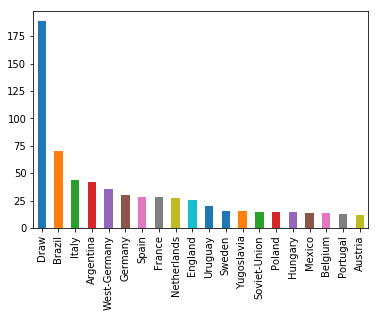

In [27]:
###Lets look at teamwise winning in world cup. So Brazil won maximum matches in worldcup
world_cup_result.Winner_Team.value_counts().head(20).plot.bar()


[(-50, 50)]

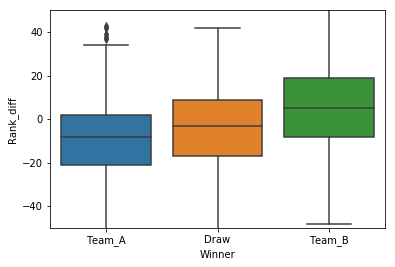

In [28]:
###Lets look how rank difference is distributed with winner. So Rank Difference is an important parameter 
hist_data=Final_Cleaned_data[Final_Cleaned_data.Year <2018]
box=sns.boxplot(x="Winner",y="Rank_diff",data=hist_data)
box.set(ylim=(-50, 50))


In [29]:
hist_data_var=['Winner','win_diff_h2h_wc_match','draw_h2h_wc_per_match','win_diff_h2h_all_match','draw_h2h_all_per_match','win_diff_h2h_all_match_percent','win_diff_h2h_all_match_10yr','draw_h2h_all_per_match_10yr','win_percent_diff_wc','Draw_percent_diff_wc','win_diff_last_10_match','Rank_diff','Appearance_diff']

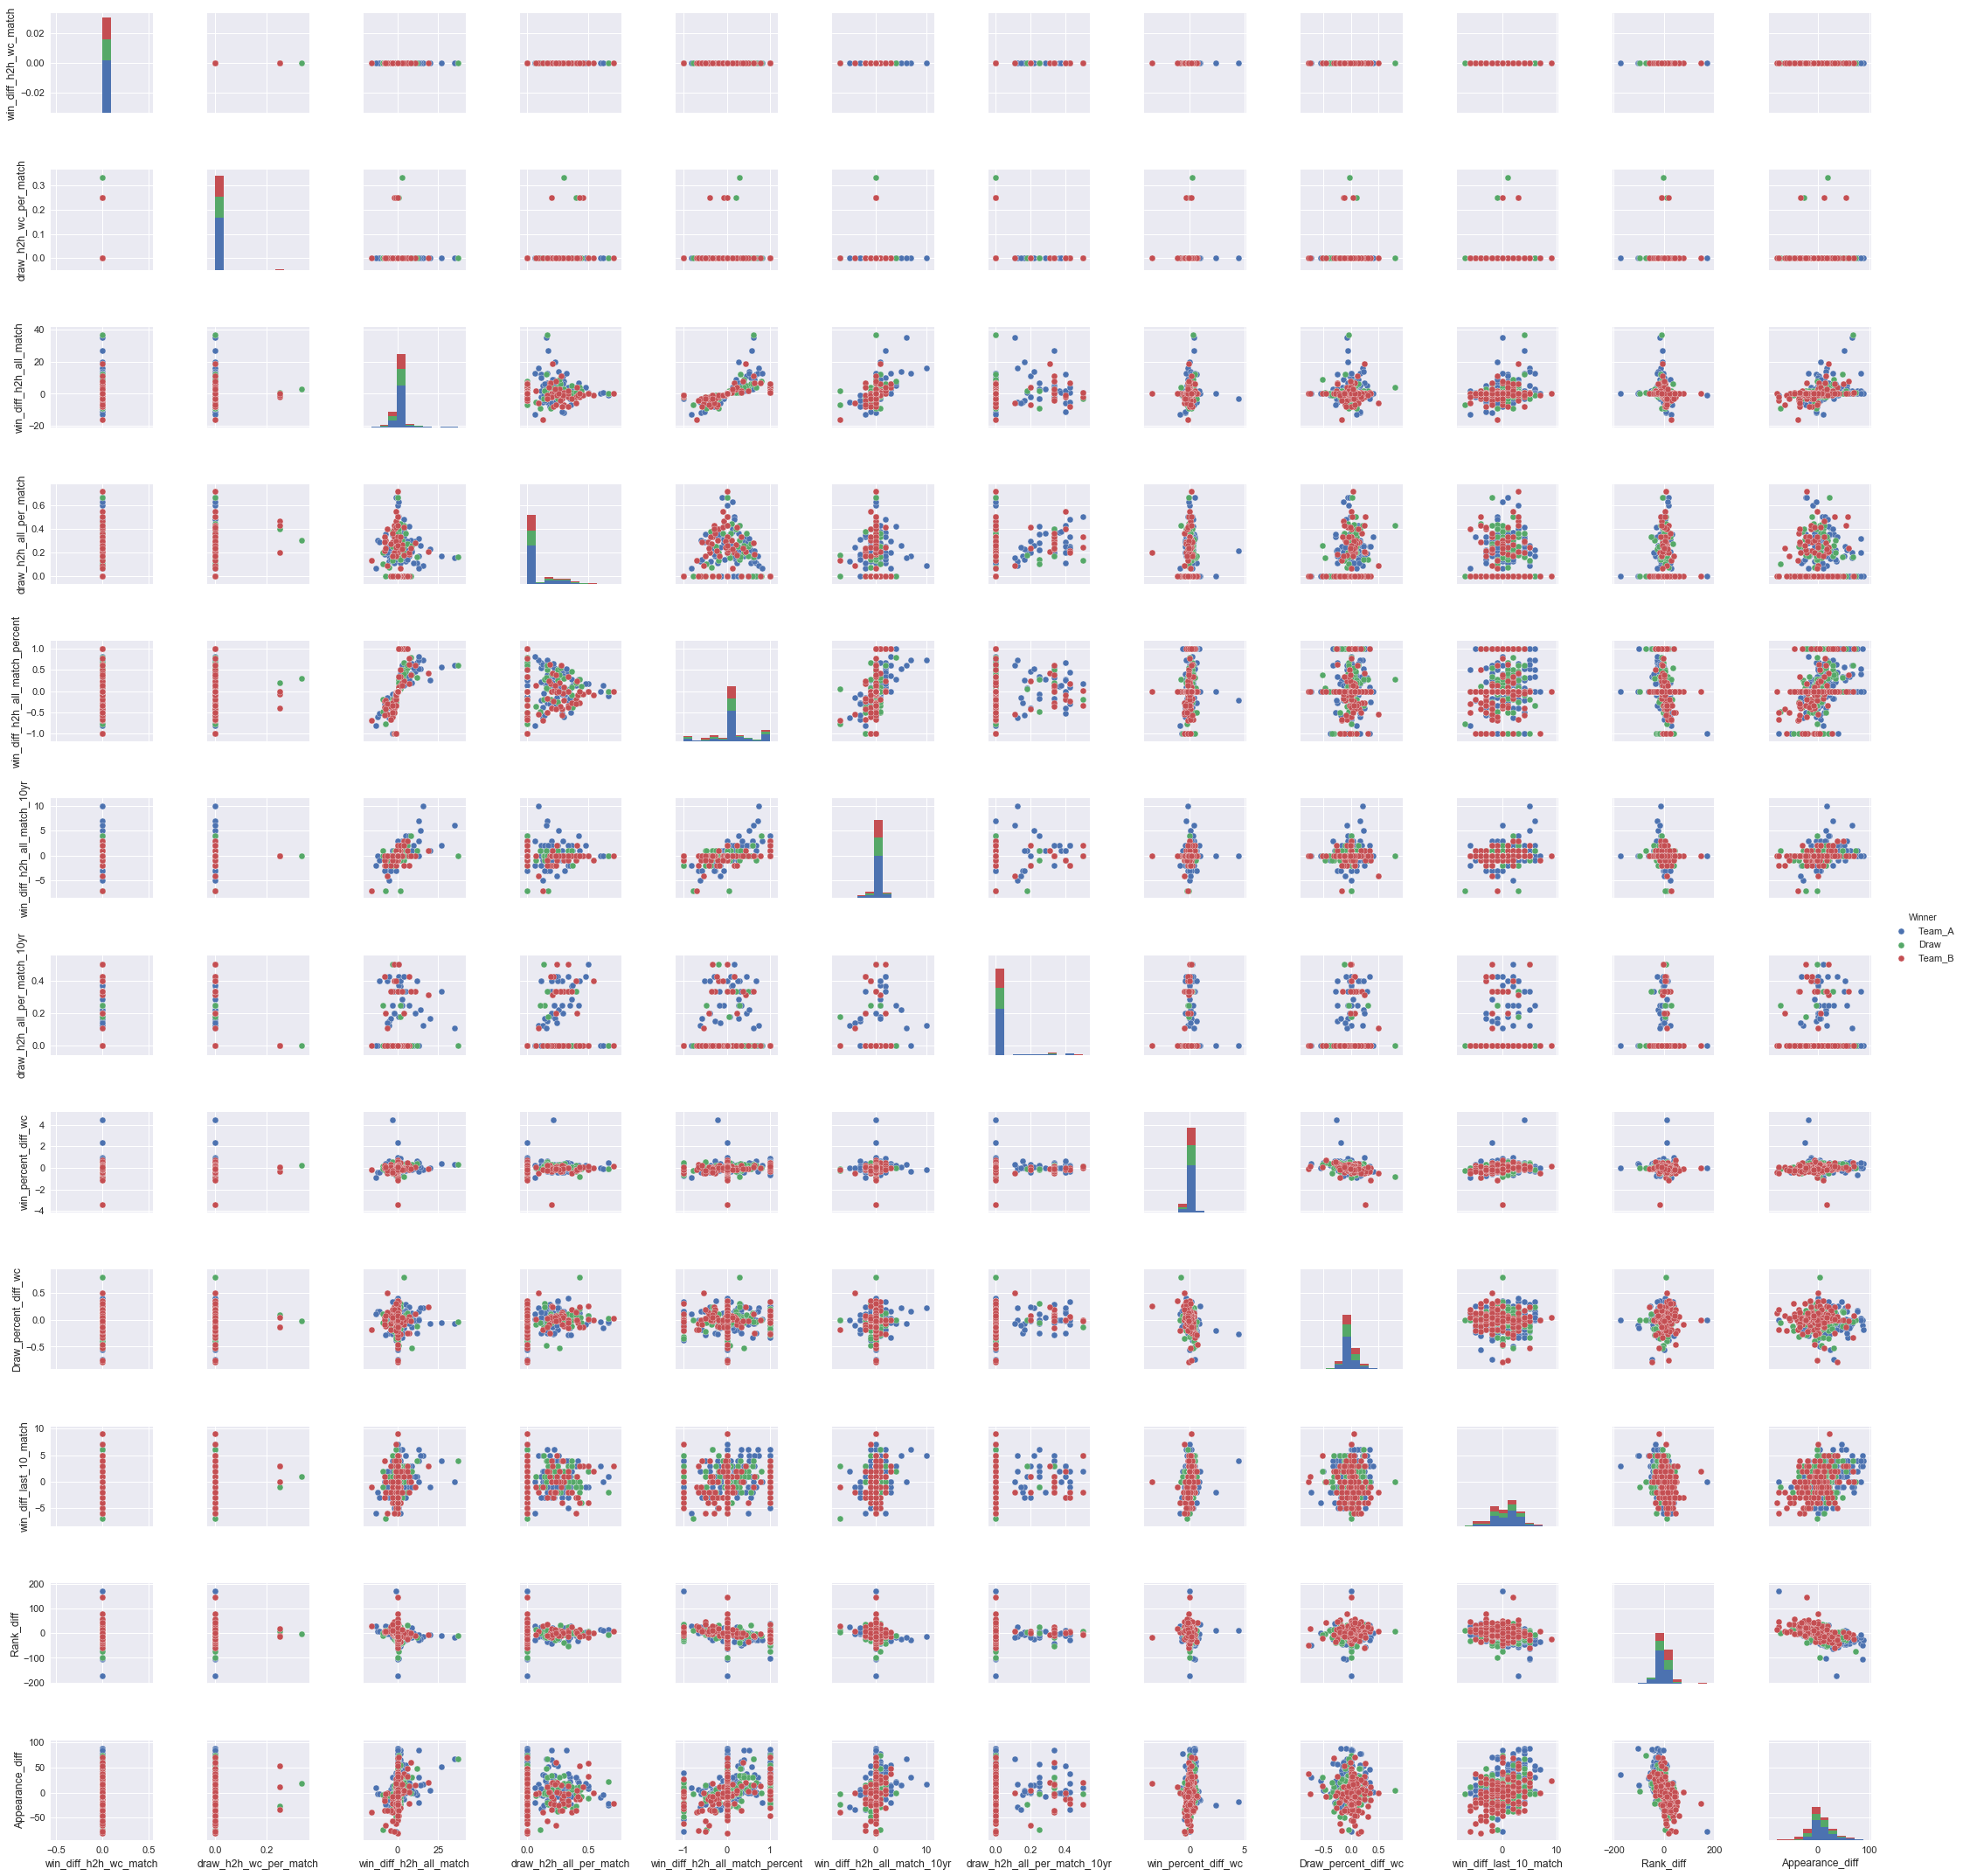

In [30]:
###Correlation plot between all numeric attributes. 
#sns.set_context("paper", rc={"axes.labelsize":12})
sns.set(font_scale=1.1)
sns.pairplot(hist_data[hist_data_var],kind="scatter",hue="Winner")


# Model fitting starts here..............

In [31]:
#wc_data=pd.read_csv("D:\\Data Science\\World Cup\\Model_data_selected_features.csv",index_col=0)
wc_data=Model_data_selected_features

###Consider data from 1950 because before this years data is not consistent
wc_data=wc_data[wc_data.Year>=1950]

In [32]:
##Create dummy variable for round

dummies_Round_df = pd.get_dummies(wc_data['Round'],prefix='Round_')#.rename(columns=lambda x: 'Round_' + str(x)))
wc_data_incld_dummies_Round = pd.concat([wc_data, dummies_Round_df], axis=1)
wc_data_incld_dummies_Round.drop(['Round'], inplace=True, axis=1)

##Create dummy variable for Team_A
dummies_Team_A = pd.get_dummies(wc_data['Team_A'],prefix='Team_A_')
wc_data_incld_dummies_Team_A = pd.concat([wc_data_incld_dummies_Round, dummies_Team_A], axis=1)
wc_data_incld_dummies_Team_A.drop(['Team_A'], inplace=True, axis=1)

##Create dummy variable for Team_B
dummies_Team_B = pd.get_dummies(wc_data['Team_B'],prefix='Team_B_')
wc_data_incld_dummies_Team_B = pd.concat([wc_data_incld_dummies_Team_A, dummies_Team_B], axis=1)
wc_data_incld_dummies_Team_B.drop(['Team_B'], inplace=True, axis=1)

In [33]:
var_to_use_in_model=['win_diff_h2h_wc_match','draw_h2h_wc_per_match','win_diff_h2h_all_match','draw_h2h_all_per_match','win_diff_h2h_all_match_percent','win_diff_h2h_all_match_10yr','draw_h2h_all_per_match_10yr','win_percent_diff_wc','Draw_percent_diff_wc','win_diff_last_10_match','Rank_diff','Appearance_diff']
dummies_Round_col=wc_data_incld_dummies_Round.columns[wc_data_incld_dummies_Round.columns.str.startswith('Round')].values.tolist()
#dummies_Year=wc_data_incld_dummies_Year.columns[wc_data_incld_dummies_Year.columns.str.startswith('Year')].values.tolist()
dummies_Team_A_col=wc_data_incld_dummies_Team_A.columns[wc_data_incld_dummies_Team_A.columns.str.startswith('Team')].values.tolist()
dummies_Team_B_col=wc_data_incld_dummies_Team_B.columns[wc_data_incld_dummies_Team_B.columns.str.startswith('Team')].values.tolist()
var_to_use_in_model=np.append(np.append(np.append(var_to_use_in_model,dummies_Round_col),dummies_Team_A_col),dummies_Team_B_col)
target = 'Winner'

In [34]:
##We can use Team Name and Round as well but for now we are using only numerical features
var_to_use_in_model=['win_diff_h2h_wc_match','draw_h2h_wc_per_match','win_diff_h2h_all_match','draw_h2h_all_per_match','win_diff_h2h_all_match_percent','win_diff_h2h_all_match_10yr','draw_h2h_all_per_match_10yr','win_percent_diff_wc','Draw_percent_diff_wc','win_diff_last_10_match','Rank_diff','Appearance_diff']
#var_to_use_in_model=['Rank_diff','Appearance_diff']

In [35]:
##Train-Test split..World cup 2014 we are considering as our test data
def train_test_split(df,var_x,var_y):
    x_train = df[df.Year<2014]
    var_x_train=list(set(x_train.columns) & set(var_x))
    x_train= x_train[var_x_train]
    y_train = df[df.Year<2014][target]
    x_test =df[df.Year==2014]
    var_x_test=list(set(x_test.columns) & set(var_x))
    x_test =x_test[var_x_test]
    y_test = df[df.Year==2014][target]
    return (x_train,y_train,x_test,y_test)

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
##Train-Test split..World cup 2014 we are considering as our test data
#x_train,y_train,x_test,y_test = train_test_split(wc_data_incld_dummies_Team_B[var_to_use_in_model], wc_data_incld_dummies_Team_B[target], test_size=0.3, random_state=42)

In [38]:
#x_train,y_train,x_test,y_test = train_test_split(wc_data_incld_dummies_Team_B,var_to_use_in_model,target)
##Train-Test split..70-30 split
x_train,x_test,y_train,y_test = train_test_split(wc_data_incld_dummies_Team_B[var_to_use_in_model], wc_data_incld_dummies_Team_B[target], test_size=0.3, random_state=42)
print ("x_train_shape",x_train.shape)
print ("y_train_shape",y_train.shape)
print ("x_test_shape",x_test.shape)
print ("y_test_shape",y_test.shape)
#x_train,y_train,x_test,y_test = train_test_split(wc_data,var_to_use_in_model,target)

x_train_shape (441, 12)
y_train_shape (441,)
x_test_shape (189, 12)
y_test_shape (189,)


In [39]:
##Create a dataframe which will be used for feature selection
features = pd.DataFrame()
features['feature'] = x_train.columns

In [40]:
##Scaling data
scaler = preprocessing.MinMaxScaler().fit(x_train)
x_train=scaler.transform(x_train)        
x_test=scaler.transform(x_test)        

In [41]:
# save the model to disk
#filename = 'D:\\Data Science\\World Cup\\scaling_model.sav'
#pickle.dump(scaler, open(filename, 'wb'))

In [42]:
##Calculate feature importance
clf = ExtraTreesClassifier(n_estimators=500)
clf = clf.fit(x_train, y_train)

features['importance'] = clf.feature_importances_
features.sort_values(['importance'],ascending=False)

,feature,importance
11,Appearance_diff,0.184683
10,Rank_diff,0.176950
8,Draw_percent_diff_wc,0.129989
9,win_diff_last_10_match,0.126375
7,win_percent_diff_wc,0.120819
2,win_diff_h2h_all_match,0.064735
4,win_diff_h2h_all_match_percent,0.063798
5,win_diff_h2h_all_match_10yr,0.057465
3,draw_h2h_all_per_match,0.048877
6,draw_h2h_all_per_match_10yr,0.020695


In [43]:
# #Select only important features
# model = SelectFromModel(clf, prefit=True)
# x_train_new = model.transform(x_train)
# x_train_new.shape
# x_test_new = model.transform(x_test)
# x_test_new.shape

In [44]:
##Use all features either one of this or above will be executed. We will use all features as it is giving better accuracy
x_train_new=x_train
x_test_new=x_test

In [45]:
##Fit logistic regression
#clf = LogisticRegression(multi_class='multinomial', solver='newton-cg')
#clf.fit(x_train_new,y_train)
#y_pred=clf.predict(x_test_new)

In [46]:
##Fit Random Forest classification
clf = RandomForestClassifier(n_estimators=100, max_depth=None,min_samples_split=2,max_features='sqrt', random_state=0,oob_score=True)
clf.fit(x_train_new,y_train)
y_pred=clf.predict(x_test_new)

In [47]:
# ##Fit Random Forest classification
# clf = svm.SVC(gamma='auto', kernel='rbf',decision_function_shape='ovo')
# clf.fit(x_train_new,y_train)
# y_pred=clf.predict(x_test_new)

In [48]:
# clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01,max_depth=3, random_state=0)
# clf.fit(x_train_new, y_train)
# y_pred=clf.predict(x_test_new)

In [49]:
clf.score(x_train_new,y_train)

clf.score(x_test_new,y_test)

0.5502645502645502

In [50]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 3],
    'max_features': [2, 3, 4],
    'n_estimators': [100, 200, 300, 500]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(x_train_new, y_train)
grid_search.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   23.1s finished


{'bootstrap': True, 'max_depth': 3, 'max_features': 4, 'n_estimators': 300}

In [51]:
###Scoring based on best parameter
best_grid = grid_search.best_estimator_
best_grid.score(x_test_new,y_test)

0.6137566137566137

In [52]:
##Confusion Matri on test data
confusion_matrix(y_pred,y_test,labels=["Team_A","Draw","Team_B"])

array([[81, 23, 28],
       [11,  7,  6],
       [14,  3, 16]], dtype=int64)

In [53]:
# save the model to disk
#filename = 'D:\\Data Science\\World Cup\\finalized_model.sav'
#pickle.dump(clf, open(filename, 'wb'))

# Prediction for latest worldcup starts here

In [54]:
#Current_worldcup_data=pd.read_csv("D:\\Data Science\\World Cup\\Current_worldcup_data.csv",index_col=0)
Current_worldcup_data.Date = pd.to_datetime(Current_worldcup_data.Date)

##Read Historical data
#Model_data_selected_features=pd.read_csv("D:\\Data Science\\World Cup\\Model_data_selected_features.csv",index_col=0)

historical_data=Model_data_selected_features.append(Current_worldcup_data)

Current_worldcup_data.tail()

,Month,Year,Place,City,Date,Round,Team_A,Team_B,win_diff_h2h_wc_match,draw_h2h_wc_per_match,...,draw_h2h_all_per_match,win_diff_h2h_all_match_percent,win_diff_h2h_all_match_10yr,draw_h2h_all_per_match_10yr,win_percent_diff_wc,Draw_percent_diff_wc,win_diff_last_10_match,Rank_diff,Appearance_diff,Winner
931,6,2018,Russia,Yekaterinburg,2018-06-27,Group,Mexico,Sweden,0,0.0,...,0.333333,-0.222222,-1,0.0,-0.083675,-0.018458,2.0,-8.0,7,Team_B
932,6,2018,Russia,Volgograd,2018-06-28,Group,Japan,Poland,0,0.0,...,0.000000,-0.333333,0,0.0,-0.248577,0.074004,-3.0,50.0,-14,Team_B
933,6,2018,Russia,Samara,2018-06-28,Group,Senegal,Colombia,0,0.0,...,0.000000,0.000000,0,0.0,0.011111,0.288889,3.0,12.0,-13,Team_B
934,6,2018,Russia,Saransk,2018-06-28,Group,Panama,Tunisia,0,0.0,...,0.000000,0.000000,0,0.0,0.000000,0.000000,-1.0,41.0,-12,0
935,6,2018,Russia,Kaliningrad,2018-06-28,Group,England,Belgium,0,0.0,...,0.222222,0.666667,1,0.0,0.077891,0.103068,-4.0,10.0,21,0


In [55]:
# load the model from disk
#filename = 'D:\\Data Science\\World Cup\\finalized_model.sav'
#clf = pickle.load(open(filename, 'rb'))

# Scaling parameter
#filename = 'D:\\Data Science\\World Cup\\scaling_model.sav'
#scaler = pickle.load(open(filename, 'rb'))

In [56]:
##Use Dataset which has all fixture for current world cup
fixture_all_match=pd.read_csv("D:\\Data Science\\World Cup\\fixtures.csv")
fixture_all_match.head()

#Create Year column 
fixture_all_match['Date']=fixture_all_match.Date.map(lambda x: x.split(" ")[0])
fixture_all_match.Date = pd.to_datetime(fixture_all_match.Date,format="%d-%m-%Y")
fixture_all_match['Month']=fixture_all_match.Date.map(lambda x: x.month)
fixture_all_match.Month = pd.to_numeric(fixture_all_match.Month)
fixture_all_match['Year']=fixture_all_match.Date.map(lambda x: x.year)
fixture_all_match.Year = pd.to_numeric(fixture_all_match.Year)

fixture_all_match.rename(columns={'Home Team': 'Team_A','Away Team': 'Team_B' },inplace=True)

In [57]:
def prediction_function(x,match_round):
    
    ##Predict for Group Stage
    Group_Stage_matches=x[x.Round==match_round]
    var_to_use_in_model=['win_diff_h2h_wc_match','draw_h2h_wc_per_match','win_diff_h2h_all_match','draw_h2h_all_per_match','win_diff_h2h_all_match_percent','win_diff_h2h_all_match_10yr','draw_h2h_all_per_match_10yr','win_percent_diff_wc','Draw_percent_diff_wc','win_diff_last_10_match','Rank_diff','Appearance_diff']
    #var_to_use_in_model=['Rank_diff','Appearance_diff']
    Group_Stage_matches_var = Group_Stage_matches[var_to_use_in_model]

    Group_Stage_matches_var.fillna(0,inplace=True)

    Eval_data=scaler.transform(Group_Stage_matches_var)

    result_prob=pd.DataFrame(clf.predict_proba(Eval_data))
    result_prob.columns = [s + '_prob' for s in clf.classes_]

    Group_Stage_matches['Winner']=clf.predict(Eval_data)

    Group_Stage_matches=pd.concat([Group_Stage_matches.reset_index(drop=True),result_prob],axis=1)

    fixture=pd.merge(fixture_all_match.reset_index(drop=True),Group_Stage_matches[['Date','Team_A','Team_B','Winner','Draw_prob','Team_A_prob','Team_B_prob']],on=['Date','Team_A','Team_B'],how='right')

    def result_calc(x):
        if x.Winner=="Team_A":
            x.Result=x['Team_A']
        elif  x.Winner=="Team_B":
            x.Result=x['Team_B']
        elif x.Winner=="Draw" and match_round=="Group":
            x.Result="Draw"
        else:
            if x.Team_A_prob>x.Team_B_prob:
                x.Result=x['Team_A']
            else:
                x.Result=x['Team_B']
            
        return (x.Result)

    fixture.Result=fixture.apply(result_calc,axis=1)

    return fixture

In [58]:
##Group League match prediction
fixture=prediction_function(Current_worldcup_data,"Group")
fixture[['Date','Team_A','Team_B','Result','Winner','Draw_prob','Team_A_prob','Team_B_prob']]

,Date,Team_A,Team_B,Result,Winner,Draw_prob,Team_A_prob,Team_B_prob
0,2018-06-14,Russia,Saudi-Arabia,Russia,Team_A,0.33,0.46,0.21
1,2018-06-15,Egypt,Uruguay,Egypt,Team_A,0.18,0.55,0.27
2,2018-06-15,Morocco,Iran,Morocco,Team_A,0.36,0.51,0.13
3,2018-06-15,Portugal,Spain,Spain,Team_B,0.34,0.25,0.41
4,2018-06-16,France,Australia,France,Team_A,0.24,0.71,0.05
5,2018-06-16,Argentina,Iceland,Argentina,Team_A,0.07,0.83,0.10
6,2018-06-16,Peru,Denmark,Peru,Team_A,0.40,0.57,0.03
7,2018-06-16,Croatia,Nigeria,Croatia,Team_A,0.09,0.78,0.13
8,2018-06-17,Costa-Rica,Serbia,Costa-Rica,Team_A,0.24,0.51,0.25
9,2018-06-17,Germany,Mexico,Germany,Team_A,0.36,0.56,0.08


In [59]:
def score_calc(x):
    
    team_list_2018=pd.Series(np.append(x.Team_A.unique(),x.Team_B.unique()))
    team_score=[]
    for team in team_list_2018.unique():
        df1=x[x.Team_A==team] 
        df2 = x[x.Team_B==team] 
        score1 = sum(df1.Team_A_prob*3 + df1.Draw_prob*1)
        score2 = sum(df2.Team_B_prob*3 + df2.Draw_prob*1)
        total_score = score1+score2
        team_score.append ({'Team':team,'total_score':total_score, 'Group': str(df1.Group.unique())})
    team_score=pd.DataFrame(team_score)
    return team_score


#Calculate rank for each group
sc=score_calc(fixture)
sc.set_index(['Group','Team'],inplace=True)
sc.sort_index(inplace=True)

df=sc.groupby(level="Group",sort=True,as_index=True)['total_score'].rank(ascending=False,method='dense')
score_df=df.reset_index()  

score_df.head()

,Group,Team,total_score
0,['Group A'],Egypt,4.0
1,['Group A'],Russia,2.0
2,['Group A'],Saudi-Arabia,3.0
3,['Group A'],Uruguay,1.0
4,['Group B'],Iran,3.0


In [60]:
###Assign Teams for Round of 16 matches
wc_2018=world_cup_result[(world_cup_result.Year==2018)]
Round_of_16 = wc_2018[ wc_2018.Round=="Round of 16"]

Round_of_16.Team_A[0:1]=score_df[ (score_df.Group=="['Group A']") & (score_df.total_score==1.0)]["Team"]
Round_of_16.Team_B[0:1]=score_df[ (score_df.Group=="['Group B']") & (score_df.total_score==2.0)]["Team"]

Round_of_16.Team_A[1:2]=score_df[ (score_df.Group=="['Group C']") & (score_df.total_score==1.0)]["Team"]
Round_of_16.Team_B[1:2]=score_df[ (score_df.Group=="['Group D']") & (score_df.total_score==2.0)]["Team"]

Round_of_16.Team_A[2:3]=score_df[ (score_df.Group=="['Group B']") & (score_df.total_score==1.0)]["Team"]
Round_of_16.Team_B[2:3]=score_df[ (score_df.Group=="['Group A']") & (score_df.total_score==2.0)]["Team"]

Round_of_16.Team_A[3:4]=score_df[ (score_df.Group=="['Group D']") & (score_df.total_score==1.0)]["Team"]
Round_of_16.Team_B[3:4]=score_df[ (score_df.Group=="['Group C']") & (score_df.total_score==2.0)]["Team"]

Round_of_16.Team_A[4:5]=score_df[ (score_df.Group=="['Group E']") & (score_df.total_score==1.0)]["Team"]
Round_of_16.Team_B[4:5]=score_df[ (score_df.Group=="['Group F']") & (score_df.total_score==2.0)]["Team"]

Round_of_16.Team_A[5:6]=score_df[ (score_df.Group=="['Group G']") & (score_df.total_score==1.0)]["Team"]
Round_of_16.Team_B[5:6]=score_df[ (score_df.Group=="['Group H']") & (score_df.total_score==2.0)]["Team"]

Round_of_16.Team_A[6:7]=score_df[ (score_df.Group=="['Group F']") & (score_df.total_score==1.0)]["Team"]
Round_of_16.Team_B[6:7]=score_df[ (score_df.Group=="['Group E']") & (score_df.total_score==2.0)]["Team"]

Round_of_16.Team_A[7:8]=score_df[ (score_df.Group=="['Group H']") & (score_df.total_score==1.0)]["Team"]
Round_of_16.Team_B[7:8]=score_df[ (score_df.Group=="['Group G']") & (score_df.total_score==2.0)]["Team"]


In [61]:
###Update historical data based on group round result
historical_data_earlier = world_cup_result[world_cup_result.Year<2018]
historical_data_2018 = world_cup_result[(world_cup_result.Year==2018) & (world_cup_result.Round=="Group")]

##Function to create Winner attributes. This variable will be used as dependent variable.
def winner_team(x):
    if x.Winner=="Team_A":
        val = x.Team_A
    elif x.Winner=="Team_B":
        val = x.Team_B
    else:
        val = "Draw"
    return (val)        

historical_data_2018.drop(columns='Winner',axis=1,inplace=True)

htd=pd.merge(historical_data_2018,fixture[['Month','Year','Team_A','Team_B','Winner']],on=['Month','Year','Team_A','Team_B'],how="left")
##Apply winner function
htd['Winner_Team']=htd.apply(winner_team,axis=1)

historical_data=pd.concat([historical_data_earlier,htd])


historical_data=pd.concat([historical_data,Round_of_16])

historical_data.Date = pd.to_datetime(historical_data.Date)
historical_data.Date=historical_data.Date.map(lambda x: np.datetime64(x))

In [62]:
##Round of 16 Prediction
World_cup_Round_of_16 = feature_engineering_module(Round_of_16)

##Prediction for Round of 16
fixture=prediction_function(World_cup_Round_of_16,"Round of 16")

fixture[['Date','Team_A','Team_B','Result','Winner','Draw_prob','Team_A_prob','Team_B_prob']]

World cup head to head statistics complete...
All match head to head statistics complete...
last 10 years all match head to head statistics complete...
Individual team performance statistics complete...
Individual team performance in world cup statistics complete...
Individual team performance in all match last 10 years statistics complete...
Rank calculation complete...
Match calculation complete...
Merging all features complete...
Comparative feature creation complete...


,Date,Team_A,Team_B,Result,Winner,Draw_prob,Team_A_prob,Team_B_prob
0,2018-06-30,Uruguay,Portugal,Uruguay,Team_A,0.25,0.39,0.36
1,2018-06-30,France,Croatia,France,Team_A,0.10,0.73,0.17
2,2018-07-01,Spain,Russia,Spain,Draw,0.45,0.43,0.12
3,2018-07-01,Argentina,Peru,Argentina,Team_A,0.35,0.45,0.20
4,2018-07-02,Brazil,Mexico,Brazil,Team_A,0.27,0.69,0.04
5,2018-07-02,England,Colombia,England,Team_A,0.18,0.76,0.06
6,2018-07-03,Germany,Switzerland,Germany,Team_A,0.31,0.46,0.23
7,2018-07-03,Poland,Belgium,Poland,Team_A,0.22,0.59,0.19


In [63]:
###Prediction for Quarter finals
###Assign Teams for Quarter-final matches
wc_2018=world_cup_result[(world_cup_result.Year==2018)]
QF = wc_2018[ wc_2018.Round=="Quarter-Finals"]
QF.Date = pd.to_datetime(QF.Date)

QF.Team_A[0:1]=fixture.Result[0]
QF.Team_B[0:1]=fixture.Result[1]

QF.Team_A[1:2]=fixture.Result[4]
QF.Team_B[1:2]=fixture.Result[5]

QF.Team_A[2:3]=fixture.Result[2]
QF.Team_B[2:3]=fixture.Result[3]

QF.Team_A[3:4]=fixture.Result[6]
QF.Team_B[3:4]=fixture.Result[7]

historical_data=pd.concat([historical_data,QF])
historical_data.Date = pd.to_datetime(historical_data.Date)

##QF feature engineering
World_cup_QF = feature_engineering_module(QF)

##Prediction for QF
fixture=prediction_function(World_cup_QF,"Quarter-Finals")

fixture[['Date','Team_A','Team_B','Result','Winner','Draw_prob','Team_A_prob','Team_B_prob']]

World cup head to head statistics complete...
All match head to head statistics complete...
last 10 years all match head to head statistics complete...
Individual team performance statistics complete...
Individual team performance in world cup statistics complete...
Individual team performance in all match last 10 years statistics complete...
Rank calculation complete...
Match calculation complete...
Merging all features complete...
Comparative feature creation complete...


,Date,Team_A,Team_B,Result,Winner,Draw_prob,Team_A_prob,Team_B_prob
0,2018-07-06,Uruguay,France,France,Team_B,0.28,0.34,0.38
1,2018-07-06,Brazil,England,Brazil,Team_A,0.38,0.41,0.21
2,2018-07-07,Spain,Argentina,Spain,Draw,0.56,0.31,0.13
3,2018-07-07,Germany,Poland,Germany,Team_A,0.13,0.56,0.31


In [64]:
##Prediction for Semi Final Match
###Assign Teams for Semi-final matches
wc_2018=world_cup_result[(world_cup_result.Year==2018)]
SF = wc_2018[ wc_2018.Round=="Semi-Finals"]
SF.Date = pd.to_datetime(SF.Date)

SF.Team_A[0:1]=fixture.Result[0]
SF.Team_B[0:1]=fixture.Result[1]

SF.Team_A[1:2]=fixture.Result[2]
SF.Team_B[1:2]=fixture.Result[3]

historical_data=pd.concat([historical_data,SF])
historical_data.Date = pd.to_datetime(historical_data.Date)

SF

##QF feature engineering
World_cup_SF = feature_engineering_module(SF)

##Prediction for SF
fixture=prediction_function(World_cup_SF,"Semi-Finals")

fixture[['Date','Team_A','Team_B','Result','Winner','Draw_prob','Team_A_prob','Team_B_prob']]

World cup head to head statistics complete...
All match head to head statistics complete...
last 10 years all match head to head statistics complete...
Individual team performance statistics complete...
Individual team performance in world cup statistics complete...
Individual team performance in all match last 10 years statistics complete...
Rank calculation complete...
Match calculation complete...
Merging all features complete...
Comparative feature creation complete...


,Date,Team_A,Team_B,Result,Winner,Draw_prob,Team_A_prob,Team_B_prob
0,2018-07-10,France,Brazil,Brazil,Team_B,0.25,0.17,0.58
1,2018-07-11,Spain,Germany,Spain,Draw,0.42,0.30,0.28


In [65]:
###Assign Teams for Final matches
wc_2018=world_cup_result[(world_cup_result.Year==2018)]
Finals = wc_2018[ wc_2018.Round=="Final"]
Finals.Date = pd.to_datetime(Finals.Date)

Finals.Team_A[0:1]=fixture.Result[0]
Finals.Team_B[0:1]=fixture.Result[1]

historical_data=pd.concat([historical_data,Finals])
historical_data.Date = pd.to_datetime(historical_data.Date)

Finals

##QF feature engineering
World_cup_Finals = feature_engineering_module(Finals)

##Prediction for Final
fixture=prediction_function(World_cup_Finals,"Final")

World cup head to head statistics complete...
All match head to head statistics complete...
last 10 years all match head to head statistics complete...
Individual team performance statistics complete...
Individual team performance in world cup statistics complete...
Individual team performance in all match last 10 years statistics complete...
Rank calculation complete...
Match calculation complete...
Merging all features complete...
Comparative feature creation complete...


In [66]:
print ("World Cup winner is :",fixture.Result[0])

World Cup winner is : Brazil
